# SHAP

[SHAP](https://github.com/slundberg/shap)'s goal is to explain machine learning output using a game theoretic approach. A primary use of SHAP is to understand how variables and values influence predictions visually and quantitatively. The API of SHAP is built along the `explainers`. These explainers are appropriate only for certain types or classes of algorithms. For example, you should use the `TreeExplainer` for tree-based models. Below, we take a look at three of these explainers.

Note that SHAP is a part of the movement to promote `explanable artificial intelligence (AI)`. There are other APIs available that do similar things to SHAP.

- [LIME](https://github.com/marcotcr/lime)
- [Alibi](https://docs.seldon.io/projects/alibi/en/stable/index.html)
- [ELI5](https://eli5.readthedocs.io/)

A great book on explanable AI or interpretable machine learning is [available online](https://christophm.github.io/interpretable-ml-book/).

## Linear explainer

The `LinearExplainer` is used to understand the outputs of linear predictors (e.g. linear regression). We will generate some data and use the `LinearRegression` model to learn the parameters from the data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from patsy import dmatrices
from numpy.random import normal
import matplotlib.pyplot as plt

np.random.seed(37)

n = 100

x_0 = normal(10, 1, n)
x_1 = normal(5, 2.5, n)
x_2 = normal(20, 1, n)
y = 3.2 + (2.7 * x_0) - (4.8 * x_1) + (1.3 * x_2) + normal(0, 1, n)

df = pd.DataFrame(np.hstack([
    x_0.reshape(-1, 1), 
    x_1.reshape(-1, 1),
    x_2.reshape(-1, 1),
    y.reshape(-1, 1)]), columns=['x0', 'x1', 'x2', 'y'])

y, X = dmatrices('y ~ x0 + x1 + x2 - 1', df, return_type='dataframe')
print(f'X shape = {X.shape}, y shape {y.shape}')

X shape = (100, 3), y shape (100, 1)


In [2]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

LinearRegression()

Before you can use SHAP, you must initialize the `JavaScript`.

In [3]:
import shap
shap.initjs()

Here, we create the `LinearExplainer`. We have to pass in the dataset `X`.

In [4]:
explainer = shap.LinearExplainer(model, X)
shap_values = explainer.shap_values(X)

A force plot can be used to explain each individual data point's prediction. Below, we look at the force plots of the first, second and third observations (indexed 0, 1, 2).

- First observation prediction explanation: the values of x1 and x2 are pushing the prediction value downard.
- Second observation prediction explanation: the x0 value is pushing the prediction value higher, while x1 and x2 are pushing the value lower.
- Third observation prediction explanation: the x0 and x1 values are pushing the prediction value lower and the x2 value is slightly nudging the value lower.

In [5]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [6]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])

In [7]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X.iloc[2,:])

The force plot can also be used to visualize explanation over all observations.

In [8]:
shap.force_plot(explainer.expected_value, shap_values, X)

The summary plot is a way to understand variable importance.

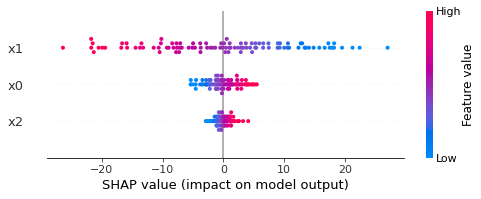

In [9]:
shap.summary_plot(shap_values, X)

Just for comparison, the visualization of the variables' importance coincide with the coefficients of the linear regression model.

In [10]:
s = pd.Series(model.coef_[0], index=X.columns)
s

x0    2.536395
x1   -4.742098
x2    1.415208
dtype: float64

## Tree explainer

The `TreeExplainer` is appropriate for algorithms using trees. Here, we generate data for a classification problem and use `RandomForestClassifier` as the model that we want to explain.

In [11]:
from scipy.stats import binom

def make_classification(n=100):
    X = np.hstack([
        np.array([1 for _ in range(n)]).reshape(n, 1),
        normal(0.0, 1.0, n).reshape(n, 1),
        normal(0.0, 1.0, n).reshape(n, 1)
    ])
    z = np.dot(X, np.array([1.0, 2.0, 3.0])) + normal(0.0, 1.0, n)
    p = 1.0 / (1.0 + np.exp(-z))
    y = binom.rvs(1, p)

    df = pd.DataFrame(np.hstack([X, y.reshape(-1, 1)]), columns=['intercept', 'x0', 'x1', 'y'])
    return df

df = make_classification()

y, X = dmatrices('y ~ x0 + x1 - 1', df, return_type='dataframe')
print(f'X shape = {X.shape}, y shape {y.shape}')

X shape = (100, 2), y shape (100, 1)


In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=37)
model.fit(X, y.values.reshape(1, -1)[0])

RandomForestClassifier(random_state=37)

In [13]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_interaction_values = explainer.shap_interaction_values(X)

Here are the forced plots for three observations.

In [14]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X.iloc[0,:])

In [15]:
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], X.iloc[1,:])

In [16]:
shap.force_plot(explainer.expected_value[1], shap_values[1][95,:], X.iloc[95,:])

Here is the force plot for all observations.

In [17]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X)

Below is the summary plot.

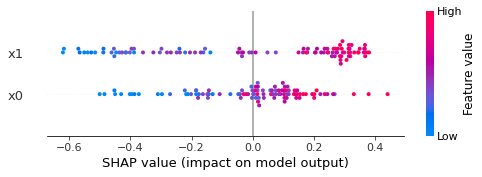

In [18]:
shap.summary_plot(shap_values[1], X)

Below are [dependence plots](https://christophm.github.io/interpretable-ml-book/pdp.html).

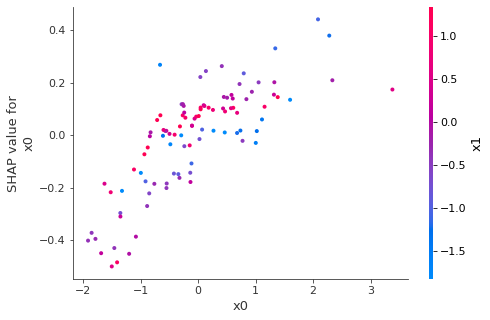

In [19]:
shap.dependence_plot('x0', shap_values[1], X)

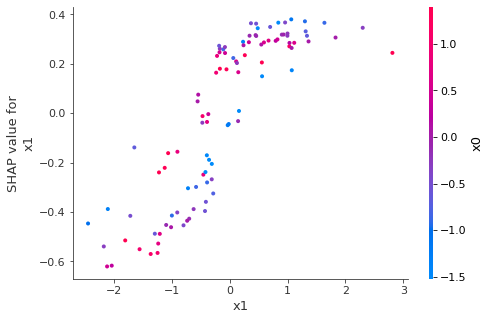

In [20]:
shap.dependence_plot('x1', shap_values[1], X)

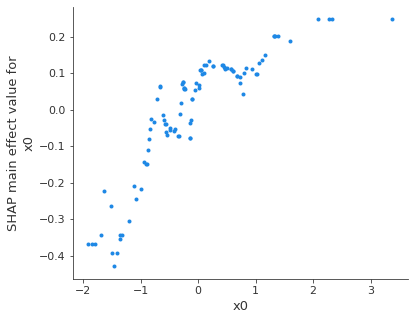

In [21]:
shap.dependence_plot(('x0', 'x0'), shap_interaction_values[1], X)

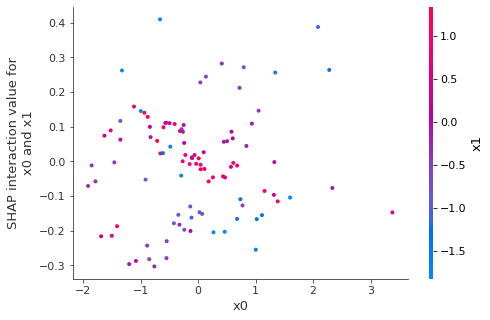

In [22]:
shap.dependence_plot(('x0', 'x1'), shap_interaction_values[1], X)

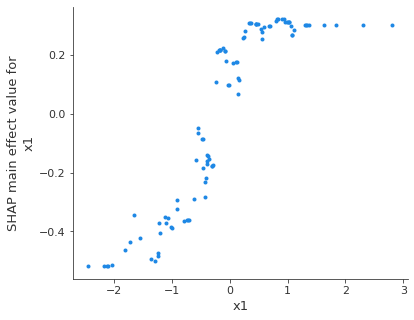

In [23]:
shap.dependence_plot(('x1', 'x1'), shap_interaction_values[1], X)

Lastly, the summary plot.

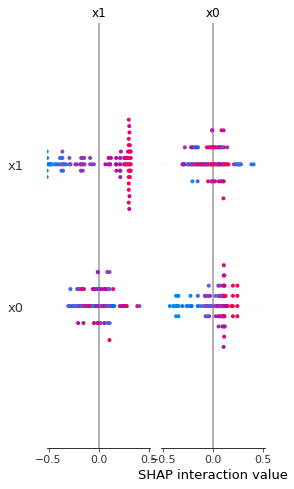

In [24]:
shap.summary_plot(shap_interaction_values[1], X)

## Kernel explainer

The `KernelExplainer` is the general purpose explainer. Here, we use it to explain the `LogisticRegression` model. Notice the `link` parameter, which can be `identity` or `logit`. This argument specifies the model link to connect the feature importance values to the model output.

In [25]:
from sklearn.linear_model import LogisticRegression

df = make_classification(n=10000)
X = df[['x0', 'x1']]
y = df.y

model = LogisticRegression(fit_intercept=True, solver='saga', random_state=37)
model.fit(X, y.values.reshape(1, -1)[0])

LogisticRegression(random_state=37, solver='saga')

In [26]:
df = make_classification()
X = df[['x0', 'x1']]
y = df.y

Observe that we pass in the proababilistic prediction function to the `KernelExplainer`.

In [27]:
explainer = shap.KernelExplainer(model.predict_proba, link='logit', data=X)
shap_values = explainer.shap_values(X)

Again, example force plots on a few observations.

In [28]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X.iloc[0,:], link='logit')

In [29]:
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], X.iloc[1,:], link='logit')

In [30]:
shap.force_plot(explainer.expected_value[1], shap_values[1][99,:], X.iloc[99,:], link='logit')

The force plot over all observations.

In [31]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X, link='logit')

Lastly, the summary plot.

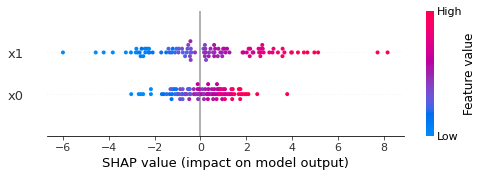

In [32]:
shap.summary_plot(shap_values[1], X)